# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy import optimize
import seaborn as sns
from theano.compile.ops import as_op
import theano.tensor as tt
import functools

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
results = pd.DataFrame()

# Load C14 models

In [3]:
import c14_models

# Read patient data

In [4]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C', '% hepa // non-hepa']]
c14_patient_data['hepa_fraction'] = c14_patient_data['% hepa // non-hepa'].apply(lambda x: x[:2]).astype('float') / 100.0
c14_patient_data['nonhepa_fraction'] = c14_patient_data['% hepa // non-hepa'].apply(lambda x: x[-2:]).astype('float') / 100.0
c14_patient_data = c14_patient_data.drop('% hepa // non-hepa', axis='columns')
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C', 'hepa_fraction', 'nonhepa_fraction']
c14_patient_data['d14C'] /= 1000.0
c14_patient_data.head()

,type,pub_id,Dbirth,Dcoll,d14C,hepa_fraction,nonhepa_fraction
0,unsorted,PH1,1942.833333,2016.416667,0.078416,0.90,0.04
1,unsorted,PH2,1991.416667,2016.833333,0.025254,0.78,0.17
2,hepatocyte,PH3,1985.166667,2016.416667,0.040336,0.76,0.13
3,hepatocyte,PH4,1982.083333,2016.500000,0.018815,0.80,0.13
4,hepatocyte,PH6,1946.500000,2004.833333,0.075001,0.68,0.25


In [5]:
f = (c14_patient_data['hepa_fraction'] / (c14_patient_data['hepa_fraction'] + c14_patient_data['nonhepa_fraction'])).mean()
d_f = (c14_patient_data['hepa_fraction'] / (c14_patient_data['hepa_fraction'] + c14_patient_data['nonhepa_fraction'])).sem()

print('f: {0:.2f}+-{1:.2f}'.format(f, d_f))

f: 0.76+-0.02


# SSE & log-likelihood

In [6]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [7]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [8]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Combined fit

In [9]:
@functools.lru_cache(maxsize=1024)
def cI1(Dbirth, Dcoll, lam):
    return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

In [10]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return cI1(Dbirth, Dcoll, lam)

In [11]:
@np.vectorize
def I2p(Dbirth, Dcoll, loglam_hep, loglam_nonhep, f):
    lam_hep = np.exp(loglam_hep)
    lam_nonhep = np.exp(loglam_nonhep)
    
    c = f * cI1(Dbirth, Dcoll, lam_hep) + \
        (1-f) * cI1(Dbirth, Dcoll, lam_nonhep)
    
    return c

## Model

In [12]:
def Nloglike_combined(p, data, f=f):
    loglam_hep, loglam_nonhep = p
    f = f
    
    hep_data = data.query('type == "hepatocyte"')
    hep_negloglike = Nloglike(loglam_hep, I1, hep_data)
    
    nonhep_data = data.query('type == "non-hepatocyte"')
    nonhep_negloglike = Nloglike(loglam_nonhep, I1, nonhep_data)
    
    unsorted_data = data.query('type == "unsorted"')
    unsorted_negloglike = Nloglike([loglam_hep, loglam_nonhep, f], I2p, unsorted_data)
    
    return hep_negloglike + nonhep_negloglike + unsorted_negloglike

## Fit

In [13]:
res = sp.optimize.brute(func=Nloglike_combined, 
                  ranges=[(-2.5, -1), (-3, 0.)],
                  args = (c14_patient_data, ),
                  Ns = 20,
                  full_output = True,
                  finish=None)

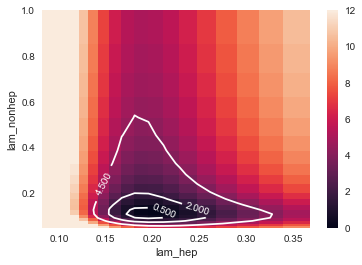

In [22]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

vmax = 12

CS = plt.contour(sp.exp(x), sp.exp(y), z, colors='white', 
           levels=[0.5, 2, 4.5])
plt.clabel(CS, inline=1, fontsize=10)

plt.pcolormesh(sp.exp(x), sp.exp(y), z, vmax=vmax)



plt.xlabel('lam_hep')
plt.ylabel('lam_nonhep')
plt.colorbar()

plt.show()

In [15]:
lam_hep = sp.exp(res[0][0])
print('lamda_hep', lam_hep)

lam_nonhep = sp.exp(res[0][1])
print('lamda_nonhep', lam_nonhep)

lamda_hep 0.195620455746
lamda_nonhep 0.109642926523


In [16]:
opt_res = sp.optimize.minimize(fun=Nloglike_combined, 
                               x0=res[0],
                               args = (c14_patient_data, ),
                               method='Nelder-Mead'
                              )

In [17]:
opt_res

 final_simplex: (array([[-1.65016128, -2.20819918],
       [-1.65015098, -2.20822553],
       [-1.65010123, -2.20814406]]), array([-88.62351287, -88.62349736, -88.62349237]))
           fun: -88.623512867961821
       message: 'Optimization terminated successfully.'
          nfev: 51
           nit: 23
        status: 0
       success: True
             x: array([-1.65016128, -2.20819918])

In [18]:
lam_hep = sp.exp(opt_res['x'][0])
print('lamda_hep', lam_hep)

lam_nonhep = sp.exp(opt_res['x'][1])
print('lamda_nonhep', lam_nonhep)

lamda_hep 0.192018938112
lamda_nonhep 0.109898377519


## Plot

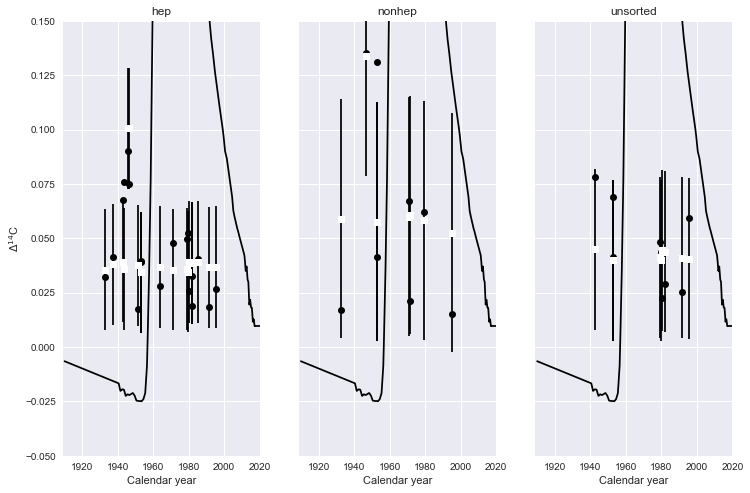

In [19]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey=True,
                       figsize=(12, 8))

time = sp.linspace(1910.0, 2020.0, 1000)

hep_data = c14_patient_data.query('type == "hepatocyte"')
nonhep_data = c14_patient_data.query('type == "non-hepatocyte"')
unsorted_data = c14_patient_data.query('type == "unsorted"')
    

for a, data in zip(ax, [hep_data, nonhep_data, unsorted_data]):
    a.plot(time, np.vectorize(c14_models.C_atm)(time), 
           label = 'Atmosphere', color = 'black')
                
    a.errorbar(data['Dbirth'], 
                data['d14C'], 
                marker = 'o', ls = 'None', color = 'black',
                label = 'Exp'
               )
    
    a.set_xlabel('Calendar year')
    
    

ax[0].errorbar(hep_data['Dbirth'], 
            I1(hep_data['Dbirth'], 
               hep_data['Dcoll'], 
               np.log(lam_hep)), 
            Sigma([lam_hep], I1, hep_data),
            color = 'white', ecolor = 'black', 
            marker='s', ls = '',
            label = 'Model')

ax[1].errorbar(nonhep_data['Dbirth'], 
            I1(nonhep_data['Dbirth'], 
               nonhep_data['Dcoll'], 
               np.log(lam_nonhep)), 
            Sigma([lam_nonhep], I1, nonhep_data),
            color = 'white', ecolor = 'black', 
            marker='s', ls = '',
            label = 'Model')

ax[2].errorbar(unsorted_data['Dbirth'], 
            I2p(unsorted_data['Dbirth'], 
               unsorted_data['Dcoll'], 
               np.log(lam_hep), np.log(lam_nonhep), f), 
            Sigma([lam_hep, lam_nonhep, f], I2p, unsorted_data),
            color = 'white', ecolor = 'black', 
            marker='s', ls = '',
            label = 'Model')


ax[0].set_title('hep')
ax[1].set_title('nonhep')
ax[2].set_title('unsorted')

ax[0].set_xlim((1909, 2020))
ax[0].set_ylim(-0.05, 0.15)
ax[0].set_xticks(sp.linspace(1910, 2010, 6), minor = 1)


ax[0].set_ylabel('$\Delta^{14}$C')

plt.show()